<a href="https://colab.research.google.com/github/kavyajeetbora/nlp_rag/blob/master/notebooks/04_rag_langchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up the environment

Takes about 3 mins to setup

In [1]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements in quiet mode.")
    !pip install -U -q torch  # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install -q PyMuPDF # for reading PDFs with Python
    !pip install -q tqdm # for progress bars
    !pip install -U -q sentence-transformers # for embedding models
    !pip install -q accelerate # for quantization model loading
    !pip install -q bitsandbytes # for quantizing models (less storage space)
    !pip install -q flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements in quiet mode.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Download the PDF

Based on which we will build our QA application

In [2]:
# The URL of the PDF you want to download
!wget "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf" -O "Human Nutrition.pdf"

--2024-12-25 14:58:34--  https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf
Resolving pressbooks.oer.hawaii.edu (pressbooks.oer.hawaii.edu)... 128.171.43.156
Connecting to pressbooks.oer.hawaii.edu (pressbooks.oer.hawaii.edu)|128.171.43.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/pdf]
Saving to: ‘Human Nutrition.pdf’

Human Nutrition.pdf     [                 <=>]  25.64M  6.99MB/s    in 3.7s    

2024-12-25 14:58:39 (6.99 MB/s) - ‘Human Nutrition.pdf’ saved [26891229]



## Read the content of the PDF

We will use PyMuPDF

In [3]:
import fitz
from tqdm.notebook import tqdm
import random

In [4]:
## Some text formatting function before extracting the text

def text_formatter(text:str)->str:
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text


## Here we can define more text preprocessing functions

About token

Tokens can be thought of as pieces of words. Before the API processes the request, the input is broken down into tokens. These tokens are not cut up exactly where the words start or end - tokens can include trailing spaces and even sub-words

Use this [tokenizer tool](https://platform.openai.com/tokenizer) to try it out

In [5]:
pdf = fitz.open('Human Nutrition.pdf')

def open_and_read_pdf(pdf_path:str) -> list[dict]:
    doc = fitz.open(pdf_path)

    pages_and_text = []

    for page_number, page in tqdm(enumerate(doc)):
        raw_text = page.get_text()
        cleaned_text = text_formatter(text=raw_text)
        pages_and_text.append(
            {
                "page_number": page_number - 41,
                "page_char_count": len(cleaned_text),
                "page_word_count": len(cleaned_text.split(" ")),
                "page_sentence_count": len(cleaned_text.split(". ")),
                "page_token_count": len(cleaned_text)/ 4, ## One token is ~ 4
                "text": cleaned_text
            }
        )

    return pages_and_text


In [6]:
pages_and_text = open_and_read_pdf("Human Nutrition.pdf")

0it [00:00, ?it/s]

In [7]:
random.sample(pages_and_text,k=3)

[{'page_number': 81,
  'page_char_count': 86,
  'page_word_count': 11,
  'page_sentence_count': 1,
  'page_token_count': 21.5,
  'text': 'http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=84  \xa0 The Digestive System  |  81'},
 {'page_number': 471,
  'page_char_count': 96,
  'page_word_count': 14,
  'page_sentence_count': 1,
  'page_token_count': 24.0,
  'text': 'view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=301  The Atom  |  471'},
 {'page_number': 830,
  'page_char_count': 1528,
  'page_word_count': 222,
  'page_sentence_count': 18,
  'page_token_count': 382.0,
  'text': 'a woman’s body weight.19 Precautions are necessary because  exposure to alcohol can negatively affect infant growth.  Benefits of Breastfeeding  Breastfeeding has a number of benefits, both for the mother and for  the child. Breast milk contains immunoglobulins, enzymes, immune  factors, and white blood cells. As a result, breastfeeding boosts  the baby’s immune system and lowers the

## Data analysis of the text

In [8]:
import pandas as pd

df = pd.DataFrame(pages_and_text)
df.sample(3)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,text
343,302,1027,181,10,256.75,Smell and Taste Fat contains dissolved compou...
438,397,635,121,7,158.75,Source: Photo courtesy of the Centers for ...
661,620,1398,233,17,349.50,in calcium absorption. During the first years ...


In [9]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


<Axes: xlabel='page_token_count', ylabel='Count'>

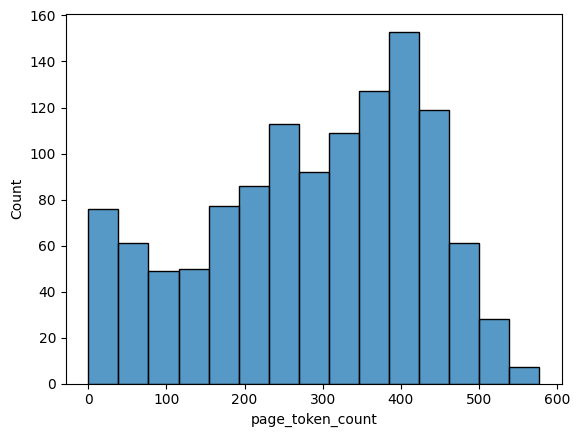

In [10]:
import seaborn as sns

sns.histplot(x='page_token_count', data=df)

Why would we care about token count ?

token count is important to think about:
1. Embedding and LLM models donot deal with infinite tokens


For example the embedding model called [all-mp-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) takes 384 tokens as input. So if we put a input with more than this then the model will cut down the text and information would be lost

As fpr LLMs, they can't accept unlimited tokens

All-mp-base-v2 is not the best embedding model out there but it is small in size so it is easy to get started. Here you can explore the leaderboard to check out the best embedding model: [MTEB Leaderboard on hugging face](https://huggingface.co/spaces/mteb/leaderboard)

## Further text processing (splitting pages into sentences)

For Splitting text into sentences we can use:
1. Manually spitting on ". "
2. Or more robust way is to use spaCy or nltk

We will use spacy [sentencizer](https://spacy.io/api/sentencizer)

In [11]:
from spacy.lang.en import English

nlp = English()

## Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

## Create document instance as an example
doc = nlp("This is a sentence. This is another sentence. And this is the last sentence")
assert len(list(doc.sents)) == 3

## Print out the sentences
list(doc.sents)

[This is a sentence., This is another sentence., And this is the last sentence]

In [12]:
for item in tqdm(pages_and_text):
    item['sentences'] = list(nlp(item['text']).sents)

    item['sentences'] = list(map(str, item['sentences']))

    item['page_sentence_count_spacy'] = len(item['sentences'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_text, k=1)

[{'page_number': 1098,
  'page_char_count': 1518,
  'page_word_count': 271,
  'page_sentence_count': 13,
  'page_token_count': 379.5,
  'text': 'Threats to Health  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  Chronic Diseases  Chronic diseases are ongoing, life-threatening, and life-altering  health challenges. They are the leading cause of death worldwide.  Chronic conditions are increasing in frequency. They cause  significant physical and emotional suffering and are an impediment  to economic growth and vitality. It is important, now more than  ever, to understand the different risk factors for chronic disease and  to learn how to prevent their development.  The Risk Factors of Chronic Disease  A risk factor is a signal that your chances for acquiring a chronic  disease may be increased. You might liken a risk factor to the flags  that lifeguards sometimes set up at beaches. When you see these  flags, you know immediately that

In [14]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


## Chunking our sentences together


The concept of splitting the larger pieces of text into smaller ones is referred to as text splitting or chunking

There is no 100% correct way of doing this. Still on research. For demonstration we will keep it simple, we will split the text into group of 10 sentences.

There are frameworks like LangChain which can help with splitting the text into chunks: [Text-Splitters in LangChain](https://python.langchain.com/docs/modules/data_connection/document_transformers/)


1. Model compatibility: You may want to split a long document into smaller chunks that can fit into your **model's context window**

Say we have a sentence like this and we tokenize it:

<img src='https://miro.medium.com/v2/resize:fit:720/format:webp/0*fS-xiimLEZDBO6JX.png' height=200/>

This long sentence results in 68 tokens. But may be there will be sentence that will be longer than this and results in tokens more than the model token limit


Also we don't want to use more tokens that may result in higher price and computation:

GPT 4 Token limits and corresponding price:

<img src='https://www.slideteam.net/media/catalog/product/cache/1280x720/c/h/chat_gpt_4_api_pricing_details_how_to_use_openai_api_in_business_chatgpt_ss_slide01.jpg' height=200/>





In [15]:
chunk_size=10

## Create a function to split the list of texts recursively into chunk size
## E.g = [20] -> [10,10] or [25] -> [10,10,5]

def split_list(input_list: list, slice_size:int) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

## Test
test_list = list(range(25))
split_list(test_list, chunk_size)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [16]:
for item in tqdm(pages_and_text):
    item['sentence_chunks'] = split_list(item['sentences'], chunk_size)
    item['num_chunks'] = len(item['sentence_chunks'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [17]:
random.sample(pages_and_text, k=1)

[{'page_number': 114,
  'page_char_count': 157,
  'page_word_count': 39,
  'page_sentence_count': 1,
  'page_token_count': 39.25,
  'text': '“Illu Urinary  System” by  Thstehle /  Public  Domain  “The  Bladder” by  OpenStax  College / CC  BY 3.0  Figure 2.22 The Bladder  114  |  The Urinary System',
  'sentences': ['“Illu Urinary  System” by  Thstehle /  Public  Domain  “The  Bladder” by  OpenStax  College / CC  BY 3.0  Figure 2.22 The Bladder  114  |  The Urinary System'],
  'page_sentence_count_spacy': 1,
  'sentence_chunks': [['“Illu Urinary  System” by  Thstehle /  Public  Domain  “The  Bladder” by  OpenStax  College / CC  BY 3.0  Figure 2.22 The Bladder  114  |  The Urinary System']],
  'num_chunks': 1}]

## Splitting each chunk into its own item



In [18]:
 import re

 pages_and_chunks = []

 for item in tqdm(pages_and_text):
    for sentence_chunk in item['sentence_chunks']:
        chunk_dict = {}
        chunk_dict['page_number'] = item['page_number']

        ## Join the sentence Chunk
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r"\.([A-Z])", r'. \1', joined_sentence_chunk) ## .A => . A; This will work with any letter

        chunk_dict['sentence_chunk'] = joined_sentence_chunk

        chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
        chunk_dict['chunk word count'] = len(joined_sentence_chunk.split(" "))
        chunk_dict['chunk_token_count'] = len(joined_sentence_chunk)/4 ## 1 token ~ 4 chars

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [19]:
random.sample(pages_and_chunks,k=1)

[{'page_number': -29,
  'sentence_chunk': 'Part\xa0VII.\xa0Chapter 7. Alcohol Introduction University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 431 Alcohol Metabolism University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 436 Health Consequences of Alcohol Abuse University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 442 Health Benefits of Moderate Alcohol Intake University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 448 Part\xa0VIII.\xa0Chapter 8. Energy Introduction University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 453 The Atom University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 460 Weight Management University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 472',
  'ch

In [20]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk word count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


<Axes: xlabel='chunk_token_count', ylabel='Count'>

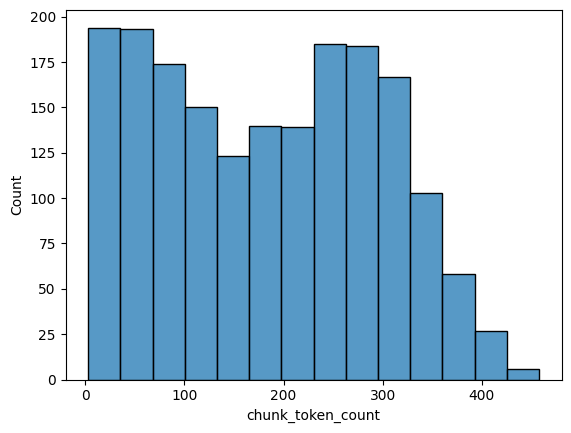

In [21]:
sns.histplot(x='chunk_token_count', data=df)

The embedding model that we are going to use has 384 token limit and from the distribution above we can see most of our chunks are having token size less than that

Also there might be sentences that are having very very less tokens which may not carry useful information for our purpose. Let's say chunks with less than 30 tokens can be considered insignificant and be removed

In [22]:
df[df['chunk_token_count']<30].sample(5)

,page_number,sentence_chunk,chunk_char_count,chunk word count,chunk_token_count
1452,930,http://pressbooks.oer.hawaii.edu/ humannutriti...,96,9,24.00
674,420,"420 | Proteins, Diet, and Personal Choices",42,7,10.50
1350,870,http://pressbooks.oer.hawaii.edu/ humannutriti...,77,6,19.25
250,147,"Published August 2011. Accessed September 22, ...",70,10,17.50
1302,837,"Complementary foods include baby meats, vegeta...",65,9,16.25


In [23]:
pages_and_chunks = df[df['chunk_token_count']>30].to_dict(orient='records')
len(pages_and_chunks)

1680

In [24]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 382,
  'sentence_chunk': 'Learning Activities Technology Note: The second edition of the Human Nutrition Open Educational Resource (OER) textbook features interactive learning activities.\xa0 These activities are available in the web-based textbook and not available in the downloadable versions (EPUB, Digital PDF, Print_PDF, or Open Document). Learning activities may be used across various mobile devices, however, for the best user experience it is strongly recommended that users complete these activities using a desktop or laptop computer and in Google Chrome. \xa0 An interactive or media element has been excluded from this version of the text. You can view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=254 \xa0 382 | Protein Digestion and Absorption',
  'chunk_char_count': 748,
  'chunk word count': 106,
  'chunk_token_count': 187.0}]

## Embedding our text chunks

what is embedding ?


In [25]:
import torch
from sentence_transformers import SentenceTransformer

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Here we are using a basic embedding model which quite fast in processing and small is size. You can instead replace this model with a more robust one but only if GPU is available on colab otherwise it will be very slow

In [27]:
embedding_model = SentenceTransformer(model_name_or_path= 'all-MiniLM-L6-v2', device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentences are encoded/embedded to a numerical representation using `model.encode()`

In [28]:
sentences = ['Embeddings are representations of values or objects like text, images, and audio that are designed to be consumed by machine learning models and semantic search algorithms.',
'They translate objects like these into a mathematical form according to the factors or traits each one may or may not have, and the categories they belong to']

embeddings = embedding_model.encode(sentences)

for sentence, embedding in zip(sentences, embeddings):
    print(f"Sentence: {sentence}")
    print(f"Shape of the embedding:{(embedding.shape)}")
    break

Sentence: Embeddings are representations of values or objects like text, images, and audio that are designed to be consumed by machine learning models and semantic search algorithms.
Shape of the embedding:(384,)


More the embedding size better the results are in capturing the sentence meaning in a vector form. But also it consumes more space and takes more time in computation.

After embedding the sentences, we can perform a vector search for retrievel of relevant text from the document.


## Embedding all the text chunks of the document

In [29]:
%%time

for item in tqdm(pages_and_chunks):
    item['embedding'] = embedding_model.encode(item['sentence_chunk'])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 17 s, sys: 178 ms, total: 17.2 s
Wall time: 17.7 s


Embedding the chunks using batch mode

In [30]:
## extract all text chunks into a list

text_chunks = [item['sentence_chunk'] for item in pages_and_chunks]
len(text_chunks)

1680

In [31]:
%%time
text_chunk_embeddings = embedding_model.encode(
    text_chunks,
    batch_size=32,
    convert_to_tensor=True
)
text_chunk_embeddings

CPU times: user 3.53 s, sys: 29.7 ms, total: 3.56 s
Wall time: 2.83 s


tensor([[-1.9507e-02, -1.8256e-02,  7.1658e-04,  ..., -3.9904e-02,
         -2.1543e-02, -4.3294e-02],
        [ 2.6605e-02,  1.8786e-03, -7.0033e-03,  ..., -2.1591e-02,
         -2.1828e-02, -6.9988e-02],
        [ 3.4971e-02,  4.0597e-02, -1.9747e-02,  ..., -3.5225e-02,
         -3.1397e-02, -4.6613e-02],
        ...,
        [-3.2258e-02, -2.4768e-02, -1.1571e-02,  ..., -1.3944e-05,
          3.9905e-02, -5.2110e-02],
        [-8.8627e-02, -6.6496e-02, -1.0430e-01,  ..., -3.0128e-02,
          8.4004e-02, -4.2208e-02],
        [-1.1203e-01, -4.9535e-02, -2.4897e-02,  ...,  1.2983e-02,
          4.6920e-02, -2.8276e-02]], device='cuda:0')

Embedding in batch mode is generally faster and preferred way.


## Saving embeddings to a file

In [32]:
df_embed = pd.DataFrame(pages_and_chunks)
df_embed.sample(5)

,page_number,sentence_chunk,chunk_char_count,chunk word count,chunk_token_count,embedding
325,213,"In fact, the treatment of drinking water is to...",196,33,49.0,"[0.050137132, 0.032431003, 0.031002467, -0.015..."
1289,909,Females require extra iron due to menstruation...,432,63,108.0,"[-0.010712949, -0.01874809, -0.03040835, 0.073..."
1616,1125,by signs similar to anorexia such as fear of b...,1554,225,388.5,"[0.06489434, -0.023257753, -0.0014847837, 0.08..."
531,350,making it easier to lose and manage weight. Ci...,904,132,226.0,"[-0.008010586, 0.028467404, 0.02251037, 0.0986..."
574,385,and the ability of these tissues to spring bac...,1288,206,322.0,"[0.03448891, -0.086648546, -0.047684915, -0.01..."


In [33]:
df_embed.to_csv('doc_embeddings.csv', index=False)

We can store these embeddings in our database instead of storing it as csv.

if the embeddings are less than 10K then it can be stored as `np.array` or `torch.tensor`

If your embedding database is really large, (eg. 1000K-1M Samples) you might want to use vector database.

[What is a vector database](https://www.pinecone.io/learn/vector-database/)